# Задание 3

## Классификация текстов

В этом задании вам предстоит попробовать несколько методов, используемых в задаче классификации, а также понять насколько хорошо модель понимает смысл слов и какие слова в примере влияют на результат.

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

from torchtext import datasets

from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator

from torchtext.vocab import Vectors, GloVe

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from tqdm.autonotebook import tqdm

В этом задании мы будем использовать библиотеку torchtext. Она довольна проста в использовании и поможет нам сконцентрироваться на задаче, а не на написании Dataloader-а.

In [ ]:
TEXT = Field(sequential=True, lower=True, include_lengths=True)  # Поле текста
LABEL = LabelField(dtype=torch.float)  # Поле метки

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Датасет на котором мы будем проводить эксперементы это комментарии к фильмам из сайта IMDB.

In [ ]:
train, test = datasets.IMDB.splits(TEXT, LABEL)  # загрузим датасет
train, valid = train.split(random_state=random.seed(SEED))  # разобьем на части

In [ ]:
# LABEL.vocab.__dict__

In [ ]:
dir(LABEL)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_first',
 'build_vocab',
 'dtype',
 'dtypes',
 'eos_token',
 'fix_length',
 'include_lengths',
 'init_token',
 'is_target',
 'lower',
 'numericalize',
 'pad',
 'pad_first',
 'pad_token',
 'postprocessing',
 'preprocess',
 'preprocessing',
 'process',
 'sequential',
 'stop_words',
 'tokenize',
 'truncate_first',
 'unk_token',
 'use_vocab',
 'vocab_cls']

In [ ]:
train[1].label

'pos'

In [ ]:
len(train[1].text)

154

In [ ]:
train[1].text

['there',
 'is',
 'no',
 'doubt',
 'that',
 'halloween',
 'is',
 'by',
 'far',
 'one',
 'of',
 'the',
 'best',
 'films',
 'ever',
 'not',
 'only',
 'in',
 'its',
 'genre',
 'but',
 'also',
 'outside.i',
 'love',
 'the',
 'films',
 'creepy',
 'atmosphere',
 'like',
 'the',
 'whole',
 'it',
 'could',
 'happen',
 'here',
 'sort',
 'of',
 'situation',
 'makes',
 'it',
 'scary',
 'to',
 'think',
 'about.also',
 'to',
 'imagine',
 'if',
 'you',
 'were',
 'ever',
 'in',
 'this',
 'situation',
 'what',
 'would',
 'you',
 'do.this',
 'is',
 'a',
 'movie',
 'that',
 'i',
 'enjoy',
 'watching',
 'highly,',
 'especially',
 'around',
 'halloween',
 'time.john',
 'carpenter',
 'is',
 'a',
 'very',
 'professional',
 'directer',
 'i',
 'love',
 'a',
 'lot',
 'of',
 'his',
 'other',
 'films,',
 'but',
 'there',
 'is',
 'no',
 'doubt',
 'that',
 'his',
 'best',
 'known',
 'movie',
 'is',
 'the',
 'film',
 'halloween.oh',
 'and',
 'if',
 'your',
 'thinking',
 'about',
 'watching',
 'the',
 'rob',
 'zombi

In [ ]:
TEXT.build_vocab(train)
LABEL.build_vocab(train)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, valid_iter, test_iter = BucketIterator.splits(
    (train, valid, test), 
    batch_size = 64,
    sort_within_batch = True,
    device = device)

## RNN

Для начала попробуем использовать рекурентные нейронные сети. На семинаре вы познакомились с GRU, вы можете также попробовать LSTM. Можно использовать для классификации как hidden_state, так и output последнего токена.

### Что такое pack_padded_sequence
[link text](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)


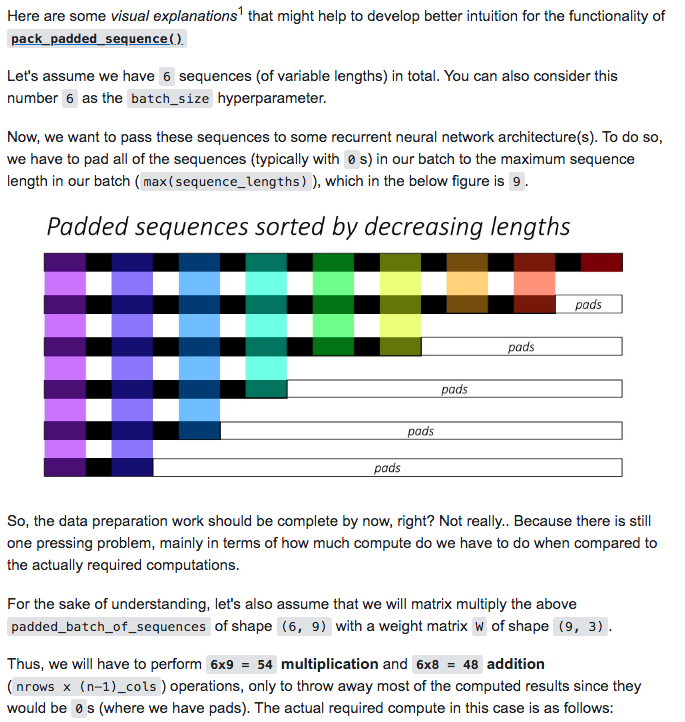
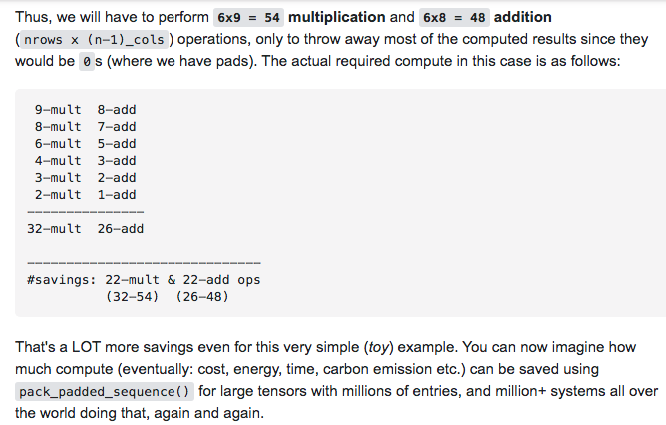

In [ ]:
class RNNBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.GRU(input_size=embedding_dim, bidirectional=bidirectional, hidden_size=hidden_dim, num_layers=n_layers, dropout=dropout)
        self.num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim*self.num_directions, 1)
        
        
    def forward(self, text, text_lengths):
        # print('forward')
        # print('text', text) # Количество комментов на батч сайз
        # print('text_lengths', text_lengths) # Сколько слов в каждом комменте

        #text = [sent len, batch size]
        # print('text.size()', text.size()) # text.size() torch.Size([272, 64])
        embedded = self.embedding(text)
        # print('embedded.size()', embedded.size()) # embedded.size() torch.Size([272, 64, 100])
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        # print('packed_embedded.size()', packed_embedded.size())
        
        # cell arg for LSTM, remove for GRU
        # packed_output, (hidden, cell) = self.rnn(packed_embedded)
        packed_output, hidden = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)  

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        # print('hidden.size()', hidden.size()) # torch.Size([4, 64, 256]) Кол-во слоёв * кол-во направлений, батч сайз, кол-во скрытого слоя
        # print('hidden', hidden)
        if self.num_directions == 2:
            # print('hidden[-2,:,:]', hidden[-2,:,:])
            # print('hidden[-1,:,:]', hidden[-1,:,:])
            # print('torch.cat((hidden[-2,:,:], hidden[-1,:,:]), 1)', torch.cat((hidden[-2,:,:], hidden[-1,:,:]), 1))
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), 1)
        else:
            # print('hidden = hidden[-1, :, :]', hidden = hidden[-1, :, :])
            hidden = hidden[-1, :, :]
                
        #hidden = [batch size, hid dim * num directions] or [batch_size, hid dim * num directions]
            
        return self.fc(hidden)

Поиграйтесь с гиперпараметрами

In [ ]:
vocab_size = len(TEXT.vocab)
emb_dim = 100
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.2
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
patience=3

In [ ]:
vocab_size

201944

In [ ]:
model = RNNBaseline(
    vocab_size=vocab_size,
    embedding_dim=emb_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    n_layers=n_layers,
    bidirectional=bidirectional,
    dropout=dropout,
    pad_idx=PAD_IDX
)

In [ ]:
model = model.to(device)

In [ ]:
model

RNNBaseline(
  (embedding): Embedding(201944, 100, padding_idx=1)
  (rnn): GRU(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

max_epochs = 20

Обучите сетку! Используйте любые вам удобные инструменты, Catalyst, PyTorch Lightning или свои велосипеды.

In [ ]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        opt.zero_grad()
        # print('batch.text[0]', batch.text[0][0])
        # print('batch.text[0]', batch.text[0].size())
        # print('batch.text[1]', batch.text[1])
        output = model(batch.text[0], batch.text[1])
        # print('output.size()', output.size()) # torch.Size([64, 1])
        # print('output.squeeze(1).size()', output.squeeze(1).size()) # torch.Size([64])
        # print('batch.label', batch.label) # 1, 0, 1, 0
        loss = loss_func(output.squeeze(1), batch.label)
        loss.backward()
        train_loss += loss.item()
        opt.step() 

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(valid_iter), total=len(valid_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        output = model(batch.text[0], batch.text[1])
        val_loss += loss_func(output.squeeze(1), batch.label).item()

    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.6310901852854847, Validation Loss: 0.5598643194820921


Epoch: 2, Training Loss: 0.4282820765336935, Validation Loss: 0.37908820681652783


Epoch: 3, Training Loss: 0.24137252759541908, Validation Loss: 0.48188740558038323


Epoch: 4, Training Loss: 0.11498960401237446, Validation Loss: 0.3966126714722585


<All keys matched successfully>

Посчитайте f1-score вашего классификатора на тестовом датасете.

**Ответ**: 0.84

In [ ]:
from sklearn.metrics import f1_score

pred_labels = []
true_labels = []
confusion_matrix = torch.zeros(2, 2)
# i = 0
for batch in test_iter:
    # i += 1
    # print(i)
    pred_labels_batch = list((model(batch.text[0], batch.text[1]) > 0.5).float().cpu().numpy().reshape(-1))
    true_labels_batch = list(batch.label.cpu().numpy())
    
    # print(pred_labels_batch[0])
    confusion_matrix[pred_labels_batch[0].astype(int), true_labels_batch[0].astype(int)] += 1
    pred_labels += pred_labels_batch
    true_labels += true_labels_batch

print(f1_score(true_labels, pred_labels))
print(confusion_matrix)

0.8430874946316325
tensor([[156.,  30.],
        [ 34., 171.]])


In [ ]:
len(pred_labels)

25000

In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
cf_matrix = confusion_matrix(pred_labels, true_labels, normalize = 'true')
print(cf_matrix)

Confusion Matrix : 
[[0.85673425 0.14326575]
 [0.17661862 0.82338138]]


In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,1,1)
ax = sns.heatmap(cf_matrix, annot=True, xticklabels=['neg','pos'], yticklabels=['neg','pos'])

NameError: ignored

## CNN

![](https://www.researchgate.net/publication/333752473/figure/fig1/AS:769346934673412@1560438011375/Standard-CNN-on-text-classification.png)

Для классификации текстов также часто используют сверточные нейронные сети. Идея в том, что как правило сентимент содержат словосочетания из двух-трех слов, например "очент хороший фильм" или "невероятноя скука". Проходясь сверткой по этим словам мы получим какой-то большой скор и выхватим его с помощью MaxPool. Далее идет обычная полносвязная сетка. Важный момент: свертки применяются не последовательно, а параллельно. Давайте попробуем!

In [ ]:
TEXT = Field(sequential=True, lower=True, batch_first=True)  # batch_first тк мы используем conv  
LABEL = LabelField(batch_first=True, dtype=torch.float)

train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

TEXT.build_vocab(trn)
LABEL.build_vocab(trn)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

Вы можете использовать Conv2d с `in_channels=1, kernel_size=(kernel_sizes[0], emb_dim))` или Conv1d c `in_channels=emb_dim, kernel_size=kernel_size[0]`. Но хорошенько подумайте над shape в обоих случаях.

In [ ]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.5,
    ):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv_0 = nn.Conv1d(emb_dim, out_channels, kernel_size=kernel_sizes[0], padding=0, stride=1)
        
        self.conv_1 = nn.Conv1d(emb_dim, out_channels, kernel_size=kernel_sizes[1], padding=0, stride=1)
        
        self.conv_2 = nn.Conv1d(emb_dim, out_channels, kernel_size=kernel_sizes[1], padding=0, stride=1)
        
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, 1)
        
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, text):
        
        embedded = self.embedding(text)
        # print('embedded.size()', embedded.size()) torch.Size([128, 984, 300]) - 128 батч, 300 - размер эмбединга
        embedded = embedded.permute(0, 2, 1)
        # print('embedded.size()', embedded.size()) torch.Size([128, 300, 984])
        conved_0 = F.relu(self.conv_0(embedded))  # may be reshape here
        conved_1 = F.relu(self.conv_1(embedded))  # may be reshape here
        conved_2 = F.relu(self.conv_2(embedded))  # may be reshape here
        
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))
            
        return self.fc(cat)

In [ ]:
kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
out_channels=64
dropout = 0.5
dim = 300

model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout)

In [ ]:
model.to(device)

CNN(
  (embedding): Embedding(201944, 300)
  (conv_0): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv_1): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (conv_2): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.BCEWithLogitsLoss()

In [ ]:
max_epochs = 30

Обучите!

In [ ]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        opt.zero_grad()
        # print(batch.text)
        output = model(batch.text)
        loss = loss_func(output.squeeze(1), batch.label)
        loss.backward()
        train_loss += loss.item()
        opt.step() 

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        # print(batch.text)
        output = model(batch.text)
        val_loss += loss_func(output.squeeze(1), batch.label).item()

    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.6600926309606455, Validation Loss: 0.12536477335428786


Epoch: 2, Training Loss: 0.5074144347305716, Validation Loss: 0.10995162417322903


Epoch: 3, Training Loss: 0.44030448250526927, Validation Loss: 0.10213260605173596


Epoch: 4, Training Loss: 0.3875015591182848, Validation Loss: 0.09660513320211638


Epoch: 5, Training Loss: 0.33940180113715845, Validation Loss: 0.08934409790119882


Epoch: 6, Training Loss: 0.27854859828948975, Validation Loss: 0.08671657134920864


Epoch: 7, Training Loss: 0.2189725730976049, Validation Loss: 0.08510881334038103


Epoch: 8, Training Loss: 0.16951745079599156, Validation Loss: 0.09004906628091457


Epoch: 9, Training Loss: 0.12475105293475798, Validation Loss: 0.08998433639437466


<All keys matched successfully>

In [ ]:
from sklearn.metrics import f1_score

pred_labels = []
true_labels = []
confusion_matrix = torch.zeros(2, 2)
# i = 0
for batch in test_iter:
    # i += 1
    # print(i)
    pred_labels_batch = list((model(batch.text) > 0.5).float().cpu().numpy().reshape(-1))
    true_labels_batch = list(batch.label.cpu().numpy())
    
    # print(pred_labels_batch[0])
    confusion_matrix[pred_labels_batch[0].astype(int), true_labels_batch[0].astype(int)] += 1
    pred_labels += pred_labels_batch
    true_labels += true_labels_batch

print(f1_score(true_labels, pred_labels))
print(confusion_matrix)

0.8527644473121748
tensor([[42.,  8.],
        [ 7., 41.]])


In [ ]:
len(pred_labels)

25000

In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
cf_matrix = confusion_matrix(pred_labels, true_labels, normalize = 'true')
print(cf_matrix)

Confusion Matrix : 
[[0.84830355 0.15169645]
 [0.1401968  0.8598032 ]]


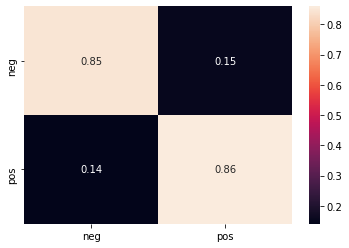

In [ ]:
import seaborn as sns
# fig = plt.figure(figsize=(10,10))
# fig.add_subplot(1,1,1)
ax = sns.heatmap(cf_matrix, annot=True, xticklabels=['neg','pos'], yticklabels=['neg','pos'])

Посчитайте f1-score вашего классификатора.

**Ответ**: 0.85

## Интерпретируемость

Посмотрим, куда смотрит наша модель. Достаточно запустить код ниже.

In [ ]:
!pip install -q captum

In [ ]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)

In [ ]:
def forward_with_softmax(inp):
    logits = model(inp)
    return torch.softmax(logits, 0)[0][1]

def forward_with_sigmoid(input):
    return torch.sigmoid(model(input))


# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def interpret_sentence(model, sentence, min_len = 7, label = 0):
    model.eval()
    text = [tok for tok in TEXT.tokenize(sentence)]
    if len(text) < min_len:
        text += ['pad'] * (min_len - len(text))
    indexed = [TEXT.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = forward_with_sigmoid(input_indices).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=5000, return_convergence_delta=True)

    print('pred: ', LABEL.vocab.itos[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)
    
def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()

    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            LABEL.vocab.itos[pred_ind],
                            LABEL.vocab.itos[label],
                            LABEL.vocab.itos[1],
                            attributions.sum(),       
                            text,
                            delta))

In [ ]:
interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 1.00 ) , delta:  tensor([0.0003], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.02 ) , delta:  tensor([5.8916e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.31 ) , delta:  tensor([1.3902e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.02 ) , delta:  tensor([8.9801e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.28 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.30 ) , delta:  tensor([0.0001], device='cuda:0', dtype=torch.float64)


Попробуйте добавить свои примеры!

In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (1.00),pos,1.50,It was a fantastic performance ! pad
pos,neg (0.02),pos,1.13,Best film ever pad pad pad pad
pos,neg (0.31),pos,1.13,Such a great show! pad pad pad
neg,neg (0.02),pos,0.23,It was a horrible movie pad pad
neg,neg (0.28),pos,1.02,I've never watched something as bad pad
neg,neg (0.30),pos,1.49,It is a disgusting movie! pad pad


## Эмбэдинги слов

Вы ведь не забыли, как мы можем применить знания о word2vec и GloVe. Давайте попробуем!

In [ ]:
TEXT.build_vocab(trn, vectors=GloVe())
# подсказка: один из импортов пока не использовался, быть может он нужен в строке выше :)
LABEL.build_vocab(trn)

word_embeddings = TEXT.vocab.vectors

kernel_sizes = [3, 4, 5]
vocab_size = len(TEXT.vocab)
dropout = 0.5
dim = 300

In [ ]:
train, tst = datasets.IMDB.splits(TEXT, LABEL)
trn, vld = train.split(random_state=random.seed(SEED))

device = "cuda" if torch.cuda.is_available() else "cpu"

train_iter, val_iter, test_iter = BucketIterator.splits(
        (trn, vld, tst),
        batch_sizes=(128, 256, 256),
        sort=False,
        sort_key= lambda x: len(x.src),
        sort_within_batch=False,
        device=device,
        repeat=False,
)

In [ ]:
model = CNN(vocab_size=vocab_size, emb_dim=dim, out_channels=64,
            kernel_sizes=kernel_sizes, dropout=dropout)

word_embeddings = TEXT.vocab.vectors

prev_shape = model.embedding.weight.shape

# model.embedding.weight = # инициализируйте эмбэдинги
model.embedding.weight.data.copy_(word_embeddings)

assert prev_shape == model.embedding.weight.shape
model.to(device)

opt = torch.optim.Adam(model.parameters())

Вы знаете, что делать.

In [ ]:
import numpy as np

min_loss = np.inf

cur_patience = 0

for epoch in range(1, max_epochs + 1):
    train_loss = 0.0
    model.train()
    pbar = tqdm(enumerate(train_iter), total=len(train_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar: 
        opt.zero_grad()
        output = model(batch.text)
        loss = loss_func(output.squeeze(1), batch.label)
        loss.backward()
        train_loss += loss.item()
        opt.step()

    train_loss /= len(train_iter)
    val_loss = 0.0
    model.eval()
    pbar = tqdm(enumerate(val_iter), total=len(val_iter), leave=False)
    pbar.set_description(f"Epoch {epoch}")
    for it, batch in pbar:
        output = model(batch.text)
        val_loss += loss_func(output.squeeze(1), batch.label).item()

    val_loss /= len(valid_iter)
    if val_loss < min_loss:
        min_loss = val_loss
        best_model = model.state_dict()
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break
    
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, train_loss, val_loss))
model.load_state_dict(best_model)

Epoch: 1, Training Loss: 0.3046012737237624, Validation Loss: 0.07636978009999809


Epoch: 2, Training Loss: 0.192849317660732, Validation Loss: 0.07414796089721938


Epoch: 3, Training Loss: 0.09672503480619758, Validation Loss: 0.07823492132001005


Epoch: 4, Training Loss: 0.038036687286013234, Validation Loss: 0.08598854594816596


<All keys matched successfully>

In [ ]:
pred_labels = []
true_labels = []
for batch in test_iter:
    pred_labels_batch = list((model(batch.text) > 0.5).float().cpu().numpy().reshape(-1))
    true_labels_batch = list(batch.label.cpu().numpy())
    
    pred_labels += pred_labels_batch
    true_labels += true_labels_batch
print(f1_score(true_labels, pred_labels))

0.8572492244053774


In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
cf_matrix = confusion_matrix(pred_labels, true_labels, normalize = 'true')
print(cf_matrix)

Confusion Matrix : 
[[0.83954972 0.16045028]
 [0.11246253 0.88753747]]


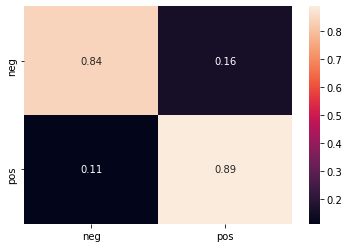

In [ ]:
import seaborn as sns
# fig = plt.figure(figsize=(10,10))
# fig.add_subplot(1,1,1)
ax = sns.heatmap(cf_matrix, annot=True, xticklabels=['neg','pos'], yticklabels=['neg','pos'])

Посчитайте f1-score вашего классификатора.

**Ответ**: 0.85

Проверим насколько все хорошо!

In [ ]:
PAD_IND = TEXT.vocab.stoi['pad']

token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)
lig = LayerIntegratedGradients(model, model.embedding)
vis_data_records_ig = []

interpret_sentence(model, 'It was a fantastic performance !', label=1)
interpret_sentence(model, 'Best film ever', label=1)
interpret_sentence(model, 'Such a great show!', label=1)
interpret_sentence(model, 'It was a horrible movie', label=0)
interpret_sentence(model, 'I\'ve never watched something as bad', label=0)
interpret_sentence(model, 'It is a disgusting movie!', label=0)

pred:  pos ( 0.99 ) , delta:  tensor([0.0002], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.01 ) , delta:  tensor([3.5143e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.09 ) , delta:  tensor([1.5085e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([3.4726e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.33 ) , delta:  tensor([9.2066e-05], device='cuda:0', dtype=torch.float64)
pred:  neg ( 0.00 ) , delta:  tensor([2.6623e-05], device='cuda:0', dtype=torch.float64)


In [ ]:
print('Visualize attributions based on Integrated Gradients')
visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
pos,pos (0.99),pos,1.68,It was a fantastic performance ! pad
pos,neg (0.01),pos,0.35,Best film ever pad pad pad pad
pos,neg (0.09),pos,1.50,Such a great show! pad pad pad
neg,neg (0.00),pos,-0.41,It was a horrible movie pad pad
neg,neg (0.33),pos,1.34,I've never watched something as bad pad
neg,neg (0.00),pos,-1.10,It is a disgusting movie! pad pad
